In [1]:
import re
import random
import pandas as pd
import hashlib

In [ ]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Asynchronous Python', 'PnP PowerShell']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
GUI Docker Container,222.492973,10.594903,24.688144,21
Linux,398.467729,12.452117,27.428133,32
"Everything is Tuberculosis, Green",303.308584,13.187330,23.961089,23
WinHex,343.750311,16.369062,22.062994,21
"The Simulacra, Dick",619.439717,32.602090,67.267228,19
Vocab,76.123225,38.061612,38.407183,2
Windows PATH Variable,1145.706977,38.190233,89.688682,30
Node.JS and React,1613.331068,52.042938,132.759075,31
"Mexican Gothic, Moreno-Garcia",1824.097066,65.146324,227.315269,28
Django,2871.610484,71.790262,253.381114,40


# Histogram

sum of ages: ~51060.67


<Axes: >

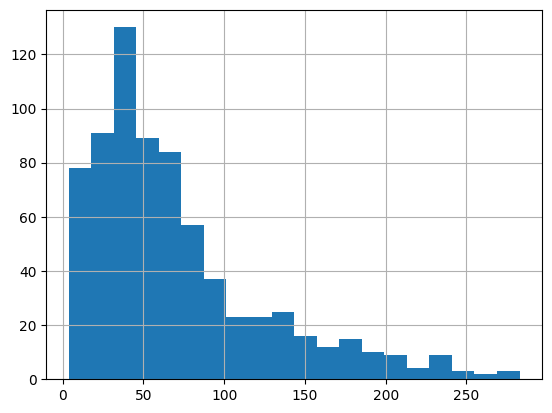

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~51060.67


<Axes: >

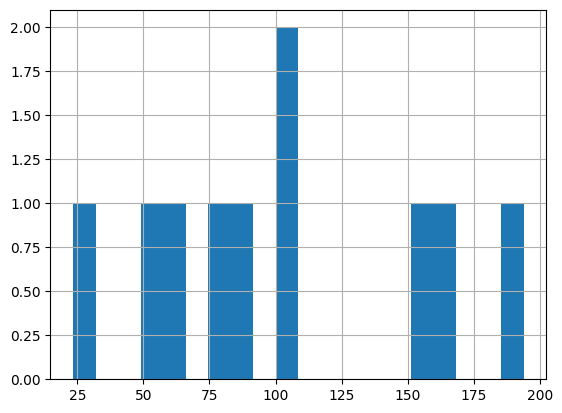

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='The Starless Crown, Rollins']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 720
Total card age: 51060.67


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
59,Power BI,Q: Why might “Rows Loaded” in Refresh History ...,8caa600733fc81daae7811252f0e753c,-227.858446,-110.438148,227.858446,2760.953706,0.695614,25,0,0
62,Power BI,Q: Why might using a Date dimension table impr...,ce59a4b3379b82ed5251b9246df9ab4e,-192.941533,-110.438148,227.858446,2760.953706,0.695614,25,3,0
187,Power BI,Q: What are common pitfalls when manually part...,8228adcbe324e385464feca329382c9d,-150.186391,-110.438148,227.858446,2760.953706,0.695614,25,6,0
190,Power BI,Q: How can Aggregations in Power BI speed up q...,fdea943e286988f0c325e545c19a815e,-133.358746,-110.438148,227.858446,2760.953706,0.695614,25,9,0
303,Power BI,Q: How do you use Performance Analyzer in Powe...,811aeb68ba7866112fd20c223436d367,-99.222712,-110.438148,227.858446,2760.953706,0.695614,25,12,0
400,Power BI,Q: How do incremental refresh policies handle ...,79dd4081ee6b2c610e75c2810a6dca21,-77.224717,-110.438148,227.858446,2760.953706,0.695614,25,15,0
402,Power BI,Q: What tool in Power BI Desktop lets you see ...,1434cb424beab645358e08fe60dfb9c3,-54.743201,-110.438148,227.858446,2760.953706,0.695614,25,18,0
471,Power BI,Q: What are the risks of using a static RangeS...,87a77d8eab93c18d9504942557a93586,-35.545439,-110.438148,227.858446,2760.953706,0.695614,25,21,0
474,Power BI,Q: What is the effect of data type mismatches ...,237db394d61828ffc8fdd92606a5ca49,-26.618910,-110.438148,227.858446,2760.953706,0.695614,25,24,0
9,Asynchronous Python,Timeouts\nTechniques like asyncio.wait_for() u...,c31a13ce25b1e193f61beaf84e6dffd8,-273.002696,-109.689454,273.002696,1425.962896,0.562837,13,0,0


## Age Max

In [10]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(-1270.7027905057846)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
104,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,-282.885245,-86.630464,282.885245,3551.849021,0.293053,41,0,0
9,Asynchronous Python,Timeouts\nTechniques like asyncio.wait_for() u...,c31a13ce25b1e193f61beaf84e6dffd8,-273.002696,-109.689454,273.002696,1425.962896,0.562837,13,0,0
114,Azure Files Documentation,Quota is a limit on the size of the file share...,3bef1cf2ec625defd17ff26244de22f9,-271.567007,-81.037082,271.567007,4619.113647,0.998357,57,0,0
14,Accounting,Allowance Method for Doubtful Accounts\nEstima...,8ab1c9af408775b6a1a9bd2d0c649d14,-267.250325,-87.482188,267.250325,1399.715011,0.266701,16,0,0
119,Python,Q:\nHow does the os.walk() function handle per...,5b22fe84dea3190c71ab1611317e290c,-256.499314,-83.118136,256.499314,6316.978349,0.571257,76,0,0
99,Django,Django App\nA self-contained feature module (e...,369de91dbb3f2242f251cc46ac43faac,-253.381114,-71.790262,253.381114,2871.610484,0.826789,40,0,0
109,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,-248.529178,-77.053936,248.529178,3467.427113,0.792993,45,0,0
15,Accounting,General Ledger (GL)\nCentral accounting record...,2e1cb1792a872ef7c0655341a20c8431,-248.393540,-87.482188,267.250325,1399.715011,0.266701,16,1,1
10,Asynchronous Python,Semaphore\nA semaphore is a synchronization to...,0013ea0c17ab1cad4c6bf84571ecc821,-240.847545,-109.689454,273.002696,1425.962896,0.562837,13,1,1
19,TSQL,Q: What does SUM(x) OVER (PARTITION BY y) do?\...,dda5b7601f3b5593f784810dd25436e7,-240.168857,-89.675537,240.168857,1524.484136,0.759763,17,0,0


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 70.918'